In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
from nilm_pre_processing import NilmPreProcessing

In [6]:
def sort_filenames(filenames, index):
    """
    Sorts a list of filenames in ascending order based on the numeric part of the filename.

    Args:
        filenames (list): A list of filenames (e.g., ["fridge_1568.xlsx", "fridge_2773.xlsx", ...])

    Returns:
        list: Sorted list of filenames
    """
    def extract_numeric_part(filename):
        # Extract the numeric part from the filename (e.g., "fridge_1568.xlsx" -> 1568)
        return int(filename.split("_")[index].split(".")[0])
    # Sort the filenames based on the numeric part
    sorted_filenames = sorted(filenames, key=extract_numeric_part)
    return sorted_filenames

def pre_processing_files(directory, label_name, index, higher_threshold, lower_threshold, offset):
    unusual_dfs = []
    labeled_dfs = []
    labeled_file_names = []
    unusual_file_names = []
    if higher_threshold < lower_threshold:
        print("Higher threshold must be higher than lower threshold")
        return None
    # iterate over files in the directory
    for filename in tqdm.tqdm(iterable=sort_filenames(os.listdir(directory), index)):
        fp = os.path.join(directory, filename)
        if os.path.isfile(fp):
            unlabeled_df = pd.read_excel(fp)
            drop_idx = []
            for i in range(offset):
                drop_idx.append(i)
                drop_idx.append(len(unlabeled_df)-1 - i)
            # Drop 2 first rows and 2 last row
            labeled_df = unlabeled_df.drop(drop_idx)
            # Attention on this code! This will drop the first column, usally the index column 
            # of the previous data
            labeled_df.drop([labeled_df.columns[0]], axis=1, inplace=True)
            power_np = labeled_df["P"].to_numpy()
            labeled_df["Label"] = label_name
            unexpected_values_higher = power_np[power_np > higher_threshold]
            unexpected_values_lower = power_np[power_np < lower_threshold]
            if (len(unexpected_values_higher) > 0) or (len(unexpected_values_lower) < 0):
                unusual_dfs.append(labeled_df)
                unusual_file_names.append(filename)
            else:
                labeled_dfs.append(labeled_df)
                labeled_file_names.append(filename)
    return labeled_dfs, labeled_file_names, unusual_dfs, unusual_file_names

In [3]:
nilm_pp = NilmPreProcessing()

In [5]:
"washing_machine_0.xlsx".split("_")[2].split(".")[0]

'0'

In [7]:
base_path = "/opt/nilm-shared-data/nilm_device_detection/other_dataset/iawe/running_segments"
label_name = "washing_machine_s1"
appliance_path = f"{base_path}/washing_machine"
labeled_dfs, labeled_file_names, unusual_dfs, unusual_file_names = pre_processing_files(directory=appliance_path, 
                                                                                        label_name=label_name, 
                                                                                        index=2, 
                                                                                        higher_threshold=300, 
                                                                                        lower_threshold=100,
                                                                                        offset=3)

100%|██████████| 20/20 [00:00<00:00, 30.28it/s]


In [8]:
print(len(labeled_dfs))
print(len(labeled_file_names))
print(len(unusual_dfs))
print(len(unusual_file_names))

17
17
3
3


## Normal files inspect

In [12]:
labeled_dfs[0].head()

,Time,unix_ts,Irms,Urms,P,Q,S,AvgPowerFactor,Label
3,2013-07-02 11:02:49+05:30,1372743169,0.973,222.35,213.821,-33.383,216.412,0.988027,washing_machine_s1
4,2013-07-02 11:02:50+05:30,1372743170,0.951,222.60,209.124,-33.281,211.756,0.987571,washing_machine_s1
5,2013-07-02 11:02:51+05:30,1372743171,0.912,222.60,200.077,-33.820,202.915,0.986014,washing_machine_s1
6,2013-07-02 11:02:52+05:30,1372743172,0.928,222.58,203.872,-33.581,206.619,0.986705,washing_machine_s1
7,2013-07-02 11:02:53+05:30,1372743173,0.952,222.65,209.279,-34.113,212.041,0.986974,washing_machine_s1


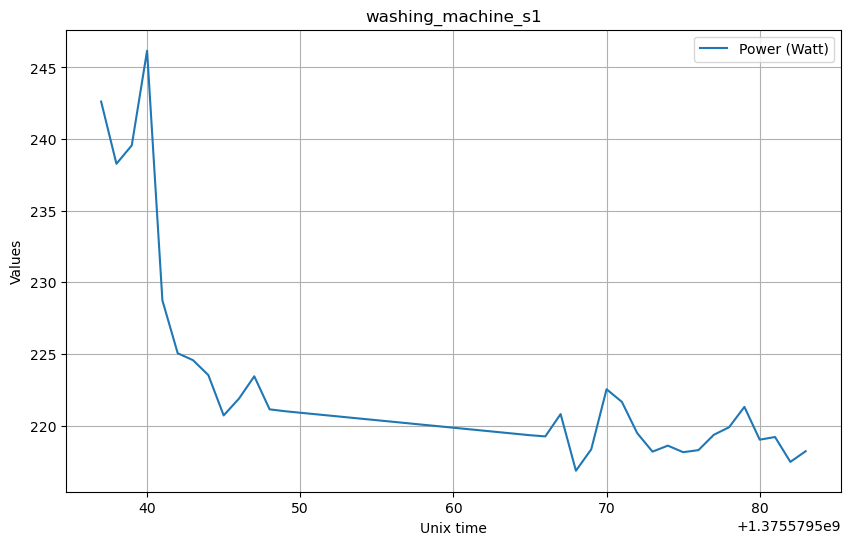

In [10]:
nilm_pp.plot_data_with_time(df=labeled_dfs[15], device_name=label_name) 

In [11]:
output_dir = f"/opt/nilm-shared-data/nilm_device_detection/other_dataset/iawe/labeled_segments/washing_machine"
for i in range(len(labeled_dfs)):
    labeled_dfs[i].to_excel(os.path.join(output_dir, f"{labeled_file_names[i]}"), index=False)

## Unusual files inspect

In [13]:
print(len(unusual_dfs))

3


In [14]:
output_dir = f"/opt/nilm-shared-data/nilm_device_detection/other_dataset/iawe/need_labeled/washing_machine"
for i in range(len(unusual_dfs)):
    unusual_dfs[i].to_excel(os.path.join(output_dir, f"{unusual_file_names[i]}"), index=False)

In [15]:
print(len(unusual_dfs[0]))

1231
